In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

# Loading the data
df = pd.read_csv('googleplaystore.csv')

In [2]:
%matplotlib inline
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

In [3]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [4]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


In [5]:
df = df.drop(i)
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

In [6]:
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))
df['Type'] = pd.get_dummies(df['Type'])
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

In [7]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [9]:
model = KNeighborsRegressor(n_neighbors=50)

In [10]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=50)

In [23]:
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 5)) + '%'

'Accuracy: 92.5466%'

In [53]:
def score_dataset(xtrain,xtest,ytrain,ytest,n_estimators):
    model1 =KNeighborsRegressor(n_neighbors=n_estimators)
    model1.fit(xtrain,ytrain)
    return model1.score(xtest,ytest)

In [54]:
index = []
score = []
for n in range(50,500,10):
    index.append(n)
    score.append(score_dataset(X_train,X_test,y_train,y_test,n,))

Text(0, 0.5, 'Accuracy')

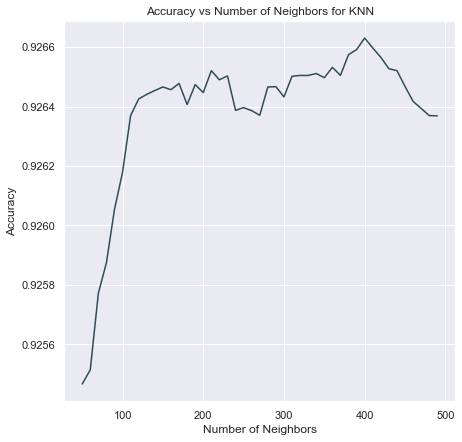

In [55]:
plt.figure(figsize=(7,7))
plt.title('Accuracy vs Number of Neighbors for KNN')
sns.lineplot(x=index,y=score)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

In [50]:
from sklearn.model_selection import GridSearchCV

knn2 = KNeighborsRegressor()

param_grid = {'n_neighbors': range(50, 500, 10)}

knn_gscv = GridSearchCV(knn2, param_grid)

knn_gscv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(50, 500, 10)})

In [51]:
knn_gscv.best_params_

{'n_neighbors': 490}

In [52]:
knn_gscv.best_score_

0.9137210520921968

In [56]:
model2 = KNeighborsRegressor(n_neighbors=400)

In [57]:
model2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=400)

In [58]:
accuracy = model2.score(X_test,y_test)
accuracy

0.9266302971856202